# Playground to implement W&B as well as start hyperparameter-tuning

## Setup

In [3]:
#%pip install seaborn

In [4]:
import re
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import wandb
from wandb.keras import WandbCallback
import keras

In [5]:
train_datapath = ["data/"+file for file in os.listdir('data') if file.endswith(".parquet")][0]
batch_size = 32

# Dataset batches + split

In [6]:
import re

def one_hot_precursor(int_value, charges=[1,2,3,4,5,6]):
    """
    One-hot encodes the precursor charge
    :param df: dataframe
    :param max_charge_included: int
    :return: dataframe
    """
    one_hot = [1 if x == int_value else 0 for x in charges]

    return one_hot

In [7]:
file_list = ["data/"+file for file in os.listdir('data') if file.endswith('.parquet')]
print(file_list[0])

data/Thermo_SRM_Pool_meta_data.parquet


### import parquet files, drop all columns we dont need for training, one-hot encode precursor charge, translate sequence

In [8]:
batches_parquet = dict()
counter = 0
for file in file_list:
    df = pd.read_parquet(file, engine='fastparquet')
    # drop all columns we dont need for training
    for column in df.columns:
        if column not in ["modified_sequence","precursor_intensity", "precursor_charge"]:
            df.drop(column, axis=1, inplace=True)
    charge_ranges = [1, 2, 3, 4, 5, 6] # TODO SET RANGES
    df = df[df["precursor_charge"].isin(charge_ranges)] # remove 7+ charge states // only take charge states 2,3,4
    df = df.dropna(subset=['precursor_intensity']) # drop rows with no precursor intensity
    batches_parquet[file] = df
    counter += 1
    #if counter > 1:
    #    break # TODO REMOVE BREAK FOR FIRST FILE IN LIST

In [9]:
vocabulary = []
vocabulary+=list('XACDEFGHIKLMNPQRSTVWY')
max_len_seq = 0

for df in batches_parquet.values():
    if max_len_seq < df['modified_sequence'].str.len().max():
        max_len_seq = df['modified_sequence'].str.len().max()
    annotations = re.findall(r'(\w\[UNIMOD:\d+\])', ' '.join(df['modified_sequence']))
    #annotations = re.findall(r'[A-Z]\[[^\]]*\]|.', ' '.join(df['modified_sequence']))
    for item in annotations:
        if item not in vocabulary:
                vocabulary.append(item)

In [10]:
print(vocabulary)
voc_len = len(vocabulary)
voc_len

['X', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'C[UNIMOD:4]', 'M[UNIMOD:35]']


23

In [11]:
num_classes = len(charge_ranges)
class_names = charge_ranges

In [12]:
batches_parquet[file_list[0]].head()

,modified_sequence,precursor_charge,precursor_intensity
0,LPGSLETYVEQEQGENANDR,2,29525630.0
1,HGSLQEYLQNDTGSK,2,13188580.0
2,VEEEEEINSELTAR,2,20663460.0
3,LPGSLETYVEQEQGENANDR,2,19884630.0
4,NSSTAEINETTTSSTDFLAR,2,12804420.0


In [13]:
file_list

['data/Thermo_SRM_Pool_meta_data.parquet',
 'data/TUM_aspn_meta_data.parquet',
 'data/TUM_first_pool_meta_data.parquet',
 'data/TUM_HLA2_meta_data.parquet',
 'data/TUM_HLA_meta_data.parquet',
 'data/TUM_isoform_meta_data.parquet',
 'data/TUM_lysn_meta_data.parquet',
 'data/TUM_missing_first_meta_data.parquet',
 'data/TUM_proteo_TMT_meta_data.parquet',
 'data/TUM_second_addon_meta_data.parquet',
 'data/TUM_second_pool_meta_data.parquet',
 'data/TUM_third_pool_meta_data.parquet']

In [14]:
batches_parquet[file_list[0]]["precursor_charge"].value_counts()

2    4331294
3    1523398
4     115577
5       2723
1       1022
6        143
Name: precursor_charge, dtype: int64

# Normalisieren:

In [15]:
def normalize_for_most_abundant(df_charge_list, df_intensity_list):
    # Get the index of the most abundant precursor intensity
    charge_dict = dict()
    for index, i in enumerate(df_charge_list):
        charge_dict[i] = []
        charge_dict[i].append(df_intensity_list[index])

    # Normalize the precursor intensity based on the most abundant precursor intensity
    for key, value in charge_dict.items():
        if len(value) > 1:
         charge_dict[key] = sum(value) - min(value) / (max(value) - min(value))

    # convert list of one float to float values
    charge_dict = {key: value[0] for key, value in charge_dict.items()}

    return charge_dict

In [16]:
def get_most_abundant(df_charge_list, df_intensity_list, distributions=False):
    # Get the index of the most abundant precursor intensity
    charge_dict = dict()
    for index, i in enumerate(df_charge_list):
        if i not in charge_dict:
            charge_dict[i] = df_intensity_list[index]
        else:
            charge_dict[i] += df_intensity_list[index]
    if distributions:
        #print(charge_dict)
        return charge_dict
    else:
        return max(charge_dict, key=charge_dict.get)


In [17]:
# load all parquets into df
df_dict = dict()
for file in file_list:
    df_dict[file] = batches_parquet[file].groupby("modified_sequence")["precursor_charge", "precursor_intensity"].agg(list).reset_index()

C:\Users\micro\AppData\Local\Temp\ipykernel_16448\2139590162.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_dict[file] = batches_parquet[file].groupby("modified_sequence")["precursor_charge", "precursor_intensity"].agg(list).reset_index()
C:\Users\micro\AppData\Local\Temp\ipykernel_16448\2139590162.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_dict[file] = batches_parquet[file].groupby("modified_sequence")["precursor_charge", "precursor_intensity"].agg(list).reset_index()
C:\Users\micro\AppData\Local\Temp\ipykernel_16448\2139590162.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_dict[file] = batches_parquet[file].groupby("modified_sequence")["precursor_charge", "precursor_intensity"].agg(list).reset_index()
C:\Users\micro\A

# init merged_df

In [18]:
merged_df = pd.concat(list(df_dict.values())).groupby("modified_sequence")["precursor_charge", "precursor_intensity"].sum().reset_index()

C:\Users\micro\AppData\Local\Temp\ipykernel_16448\1215419649.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  merged_df = pd.concat(list(df_dict.values())).groupby("modified_sequence")["precursor_charge", "precursor_intensity"].sum().reset_index()


In [19]:
merged_df['seq_len_prepadding'] = merged_df['modified_sequence'].apply(lambda x: len(x))

In [20]:
len_counts = merged_df['seq_len_prepadding'].value_counts()
seq_too_long = len_counts[len_counts <= 10]
seq_too_long

87     9
82     8
85     7
89     6
90     5
107    4
97     4
95     4
92     4
83     3
86     3
98     3
91     2
84     2
93     2
88     2
96     2
110    2
105    1
104    1
102    1
94     1
103    1
115    1
99     1
125    1
108    1
Name: seq_len_prepadding, dtype: int64

In [21]:
seq_lengths = merged_df['seq_len_prepadding'].value_counts().index.values, merged_df['seq_len_prepadding'].value_counts().values
seq_too_long = pd.DataFrame()
seq_too_long['seq_len'] = seq_lengths[0][seq_lengths[0] >= 50]
seq_too_long['count'] = seq_lengths[1][seq_lengths[0] >= 50]
seq_too_long

,seq_len,count
0,50,1087
1,51,764
2,52,595
3,53,426
4,56,385
5,57,385
6,55,382
7,58,373
8,54,366
9,59,290


In [22]:
# give smallest seq_len when count <= 100
seq_len_cutoff_df = seq_too_long[seq_too_long['count'] <= 100]
seq_len_cutoff = min(seq_len_cutoff_df['seq_len'])

In [23]:
seq_len_cutoff

64

In [24]:
# reapply max len
max_len_seq = seq_len_cutoff-1

In [25]:
def seq_translator(sequence, dictionary=vocabulary, max_len=max_len_seq, print_result=False, no_padding=False):
    """
    Translates a sequence into a vector of integers
    :param print_result:
    :param max_len:
    :param sequence: string
    :param dictionary: dictionary
    :return: list
    """
    pattern = r'[A-Z]\[[^\]]*\]|.' # regex pattern to match amino acids and modifications
    #pattern = r'(\w\[UNIMOD:\d+\])' # regex pattern to match amino acids and modifications

    result = [match for match in re.findall(pattern, sequence)]

    # Fill the list with "X" characters until it reaches a length of 40
    if not no_padding:
        result += ['X'] * (max_len - len(result))
    if print_result:
        print(result)

    aa_dictionary = dict()
    for index, aa in enumerate(dictionary):
        aa_dictionary[aa] = index

    return [aa_dictionary[aa] for aa in result]

In [26]:
delete_a_row = True
if delete_a_row:
# delete row if seq_len_prepadding larger or equal to seq_len_cutoff
    index_to_delete_seq = merged_df[merged_df['seq_len_prepadding'] >= seq_len_cutoff].index
    merged_df.drop(index_to_delete_seq, inplace=True)

In [27]:
# output all sequences with seq_len_prepadding >= 50
merged_df[merged_df['seq_len_prepadding'] >= seq_len_cutoff]

,modified_sequence,precursor_charge,precursor_intensity,seq_len_prepadding


In [28]:
merged_df['normalized'] = merged_df.apply(lambda x: normalize_for_most_abundant(x["precursor_charge"], x["precursor_intensity"]), axis=1)

In [29]:
merged_df['pre_normalization'] = merged_df.apply(lambda x: get_most_abundant(x["precursor_charge"], x["precursor_intensity"], True), axis=1)

In [30]:
# return key for max value in dict
merged_df['most_abundant_charge'] = merged_df['normalized'].apply(lambda x: max(x, key=x.get))

In [31]:
merged_df["most_abundant_charge_vector"] = merged_df["most_abundant_charge"].apply(one_hot_precursor, args=(charge_ranges,))

In [32]:
merged_df["modified_sequence_vector"] = merged_df["modified_sequence"].apply(seq_translator)

In [33]:
merged_df.head(11)

,modified_sequence,precursor_charge,precursor_intensity,seq_len_prepadding,normalized,pre_normalization,most_abundant_charge,most_abundant_charge_vector,modified_sequence_vector
0,AAAAAAAAAAAAAAAAGLGLGP,"[2, 3, 2, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, ...","[12746190.0, 2009914.0, 12746190.0, 791369.9, ...",22,"{2: 588796.3, 3: 4654280.0, 1: 791369.9}","{2: 1043873837.3, 3: 30130627.0, 1: 1582739.8}",3,"[0, 0, 1, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,AAAAAAAAAAAAAAAASAGGK,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[5944787.0, 5944787.0, 8502878.0, 6425294.0, 8...",21,{2: 303307.5},{2: 107202221.5},2,"[0, 1, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,AAAAAAAAAAAAAAAGAGAGAK,"[2, 2, 2, 2]","[3067981.0, 3067981.0, 3067981.0, 3067981.0]",22,{2: 3067981.0},{2: 12271924.0},2,"[0, 1, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,AAAAAAAAAAAAAAASGFAYPGTSER,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[11913300.0, 11913300.0, 11913300.0, 11913300....",26,"{2: 8093413.0, 3: 1414907.0}","{2: 148659685.0, 3: 4244721.0}",2,"[0, 1, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,AAAAAAAAAAAAAAG,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1573785.0, 4638296.0, 7934979.0, 2019978.0, 4...",15,{1: 1124818.0},{1: 546950229.4000001},1,"[1, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, ..."
5,AAAAAAAAAAAAAAGAG,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[853119.3, 4332449.0, 3688977.0, 3469130.0, 33...",17,{1: 679216.3},{1: 52634067.9},1,"[1, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, ..."
6,AAAAAAAAAAAAAAGGLALGLH,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[33516080.0, 33516080.0, 8522070.0, 4549188.0,...",22,{2: 365943.3},{2: 6848110396.300002},2,"[0, 1, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, ..."
7,AAAAAAAAAAAAAAVTSGV,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[4576179.0, 3336856.0, 4954145.0, 4317804.0, 3...",19,"{2: 14611910.0, 1: 1211272.0}","{2: 225462597.40000004, 1: 5840742.2}",2,"[0, 1, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 18,..."
8,AAAAAAAAAAAAAGAG,"[1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, ...","[1233316.0, 2671238.0, 11414430.0, 13683660.0,...",16,"{1: 1879604.0, 2: 2586197.0}","{1: 349665943.5, 2: 228379326.3}",2,"[0, 1, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, ..."
9,AAAAAAAAAAAAAK,"[1, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, ...","[2540360.0, 31115000.0, 31115000.0, 70371250.0...",14,"{1: 8372130.0, 2: 15308280.0}","{1: 99493666.2, 2: 6574531120.0}",2,"[0, 1, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 9, 0, ..."


In [34]:
len(merged_df)

830820

In [35]:
merged_df["most_abundant_charge"].value_counts()

2    452544
3    259972
4     65966
1     41352
5      9069
6      1917
Name: most_abundant_charge, dtype: int64

In [36]:
#get the

In [37]:
print(file_list[0])
look_up_df = batches_parquet[file_list[0]].groupby("modified_sequence")["precursor_charge", "precursor_intensity"].agg(list).reset_index()
len(look_up_df)

data/Thermo_SRM_Pool_meta_data.parquet


C:\Users\micro\AppData\Local\Temp\ipykernel_16448\365009680.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  look_up_df = batches_parquet[file_list[0]].groupby("modified_sequence")["precursor_charge", "precursor_intensity"].agg(list).reset_index()


70445

# Embedding model test:

In [38]:
df1 = merged_df.sample(frac = 0.1, random_state = 42)
test_ds_embed = np.array(df1['modified_sequence_vector'])
test_ds_embed_raw = np.array(df1['modified_sequence'])
test_labels_embed = np.array(df1['most_abundant_charge_vector'])
test_true_labels_normalized = np.array(df1['normalized'])

In [39]:
test_ds_embed = [np.array(x) for x in test_ds_embed]

In [40]:
test_labels_embed = [np.array(x) for x in test_labels_embed]

In [41]:
test_ds_embed = tf.convert_to_tensor(test_ds_embed)
test_labels_embed = tf.convert_to_tensor(test_labels_embed)

Add topk


In [51]:
def get_topK(label_dict, k=1):
    allowed_keys = list()
    sorted_values = sorted(label_dict.values(), reverse=True)
    for i in sorted_values:
        for key, value in label_dict.items():
            if i == value and len(allowed_keys) <= k:
                #allowed_keys.append((key, value))
                allowed_keys.append(key)
    return allowed_keys
df1['topK'] = df1['normalized'].apply(get_topK)

# The random predictor baseline model

In [52]:
df1.head(4)

,modified_sequence,precursor_charge,precursor_intensity,seq_len_prepadding,normalized,pre_normalization,most_abundant_charge,most_abundant_charge_vector,modified_sequence_vector,random_label,topK
202733,EVAAARAAETE,[2],[2308078.0],11,{2: 2308078.0},{2: 2308078.0},2,"[0, 1, 0, 0, 0, 0]","[4, 18, 1, 1, 1, 15, 1, 1, 4, 17, 4, 0, 0, 0, ...",3,[2]
676563,SNSLRLSLIGDR,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, ...","[235036700.0, 97028600.0, 40602360.0, 23503670...",12,"{3: 15888960.0, 2: 41187530.0}","{3: 8432234945.0, 2: 318124150.0}",2,"[0, 1, 0, 0, 0, 0]","[16, 12, 16, 10, 15, 10, 16, 10, 8, 6, 3, 15, ...",3,"[2, 3]"
187277,EM[UNIMOD:35]LTRAIKTQLVLLT,"[3, 3, 2, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, ...","[36243780.0, 20539810.0, 7780559.0, 4336029.0,...",26,"{3: 48770720.0, 2: 7114500.0}","{3: 2520368785.0, 2: 22675618.0}",3,"[0, 0, 1, 0, 0, 0]","[4, 22, 10, 17, 15, 1, 8, 9, 17, 14, 10, 18, 1...",3,"[3, 2]"
332706,IPRVTTPLSSL,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[46604460.0, 3748077.0, 46604460.0, 2759318.0,...",11,{2: 9628667.0},{2: 4689524063.0},2,"[0, 1, 0, 0, 0, 0]","[8, 13, 15, 18, 17, 17, 13, 10, 16, 16, 10, 0,...",3,[2]


In [43]:
# count all values
dist_dict_testset = dict()
for x in df1["most_abundant_charge"].value_counts().index:
    # as percentage
    print(x, df1["most_abundant_charge"].value_counts()[x], round(df1["most_abundant_charge"].value_counts()[x]/sum(df1["most_abundant_charge"].value_counts())*100, 2))
    dist_dict_testset[x] = round(df1["most_abundant_charge"].value_counts()[x]/sum(df1["most_abundant_charge"].value_counts())*100, 2)
# print total
print("total: ", sum(df1["most_abundant_charge"].value_counts()))

2 45328 54.56
3 26040 31.34
4 6503 7.83
1 4126 4.97
5 903 1.09
6 182 0.22
total:  83082


In [44]:
# count all values
dist_dict = dict()
for x in merged_df["most_abundant_charge"].value_counts().index:
    # as percentage
    print(x, merged_df["most_abundant_charge"].value_counts()[x], round(merged_df["most_abundant_charge"].value_counts()[x]/sum(merged_df["most_abundant_charge"].value_counts())*100, 2))
    dist_dict[x] = round(merged_df["most_abundant_charge"].value_counts()[x]/sum(merged_df["most_abundant_charge"].value_counts())*100, 2)
# print total
print("total: ", sum(merged_df["most_abundant_charge"].value_counts()))

2 452544 54.47
3 259972 31.29
4 65966 7.94
1 41352 4.98
5 9069 1.09
6 1917 0.23
total:  830820


In [45]:
merged_df.head(4)

,modified_sequence,precursor_charge,precursor_intensity,seq_len_prepadding,normalized,pre_normalization,most_abundant_charge,most_abundant_charge_vector,modified_sequence_vector
0,AAAAAAAAAAAAAAAAGLGLGP,"[2, 3, 2, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, ...","[12746190.0, 2009914.0, 12746190.0, 791369.9, ...",22,"{2: 588796.3, 3: 4654280.0, 1: 791369.9}","{2: 1043873837.3, 3: 30130627.0, 1: 1582739.8}",3,"[0, 0, 1, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,AAAAAAAAAAAAAAAASAGGK,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[5944787.0, 5944787.0, 8502878.0, 6425294.0, 8...",21,{2: 303307.5},{2: 107202221.5},2,"[0, 1, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,AAAAAAAAAAAAAAAGAGAGAK,"[2, 2, 2, 2]","[3067981.0, 3067981.0, 3067981.0, 3067981.0]",22,{2: 3067981.0},{2: 12271924.0},2,"[0, 1, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,AAAAAAAAAAAAAAASGFAYPGTSER,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[11913300.0, 11913300.0, 11913300.0, 11913300....",26,"{2: 8093413.0, 3: 1414907.0}","{2: 148659685.0, 3: 4244721.0}",2,"[0, 1, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [46]:
dist_dict.items()

dict_items([(2, 54.47), (3, 31.29), (4, 7.94), (1, 4.98), (5, 1.09), (6, 0.23)])

In [47]:
random_range = []
for key, value in dist_dict.items():
    for i in range(int(value)):
        random_range.append(key)

In [93]:
def random_predictor(anything, randomizer=random_range):
    return random.choice(randomizer)

In [94]:
def random_predictor_total_random(anything, randomizer=None):
    if randomizer is None:
        randomizer = [1, 2, 3, 4, 5, 6]
    return random.choice(randomizer)

In [49]:
accuracy_list = []

for num in range(1):
    # iterate through all rows of df1
    df1['random_label'] = df1['most_abundant_charge'].apply(random_predictor)
    
    correct_random = 0
    wrong_random = 0
    total_random = 0
    for index, row in df1.iterrows():
        total_random += 1
        if row['random_label'] == row['most_abundant_charge']:
            correct_random += 1
        else:
            wrong_random += 1
            
    ## return accuracy
    #print("correct: ", correct_random, "wrong: ", wrong_random, "total: ", total_random)
    #print("accuracy: ", correct_random/total_random)
    accuracy_list.append(correct_random/total_random)

In [ ]:
accuracy_list = []
topk_accuracy_list = []

accuracy_list_x = []
topk_accuracy_list_x = []

run_count = 100
for num in range(run_count):
    # iterate through all rows of df1
    df1['random_label'] = df1['most_abundant_charge'].apply(random_predictor)
    df1['random_label_x'] = df1['most_abundant_charge'].apply(random_predictor_total_random)
    total_random = 0
    
    correct_random_x = 0
    wrong_random_x = 0
        
    correct_random = 0
    wrong_random = 0

    
    topk_correct_random_x = 0
    topk_wrong_random_x = 0
        
    topk_correct_random = 0
    topk_wrong_random = 0
    
    
    for index, row in df1.iterrows():
        total_random += 1
        
        if row['random_label'] == row['most_abundant_charge']:
            correct_random += 1
        else:
            wrong_random += 1
        if row['random_label'] in row['topK']:
            topk_correct_random += 1
        else:
            topk_wrong_random += 1
            
        if row['random_label_x'] == row['most_abundant_charge']:
            correct_random_x += 1
        else:
            wrong_random_x += 1
        if row['random_label_x'] in row['topK']:
            topk_correct_random_x += 1
        else:
            topk_wrong_random_x += 1
    ## return accuracy
    #print("correct: ", correct_random, "wrong: ", wrong_random, "total: ", total_random)
    #print("accuracy: ", correct_random/total_random)
    accuracy_list.append(correct_random/total_random)
    topk_accuracy_list.append(topk_correct_random/total_random)
    
    accuracy_list_x.append(correct_random_x/total_random)
    topk_accuracy_list_x.append(topk_correct_random_x/total_random)


In [ ]:
# save to file: accuracy_list
import pickle
with open('random_accuracy_list.pickle', 'wb') as f:
    pickle.dump(accuracy_list, f)
    

In [ ]:
accuracy_list

In [ ]:
print("mean accuracy: ", np.mean(accuracy_list))

In [ ]:
print("len_list accuracy: ", len(accuracy_list))

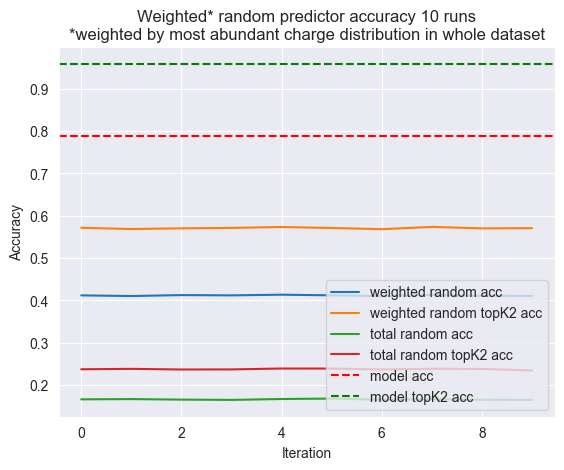

In [99]:
# plot accuracy_list for accuracy from 0% to 100% and add a vertical line at 78,74%
plt.plot(accuracy_list)
plt.plot(topk_accuracy_list)
plt.plot(accuracy_list_x)
plt.plot(topk_accuracy_list_x)

plt.axhline(y=0.7874, color='r', linestyle='--')
plt.axhline(y=0.9582, color='g', linestyle='--')
# add legend
plt.legend(['weighted random acc', 'weighted random topK2 acc','total random acc', 'total random topK2 acc', 'model acc','model topK2 acc', ], loc='lower right')
# add title
plt.title(f'Weighted* random predictor accuracy {run_count} runs\n*weighted by most abundant charge distribution in whole dataset')
# add x and y labels
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
# show plot
plt.show()

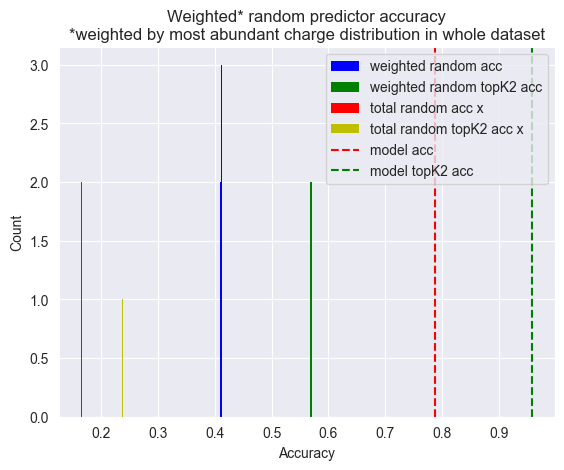

In [98]:
# plot accuracy_list as barplot
# y as count of how many times the accuracy was achieved
# x as accuracy
plt.hist(accuracy_list, bins=10, color='b', label='weighted random acc', linewidth=0, edgecolor='black')
plt.hist(topk_accuracy_list, bins=10, color='g', label='weighted random topK2 acc', linewidth=0, edgecolor='black')
plt.hist(accuracy_list_x, bins=10, color='r', label='total random acc x', linewidth=0, edgecolor='black')
plt.hist(topk_accuracy_list_x, bins=10, color='y', label='total random topK2 acc x', linewidth=0, edgecolor='black')

plt.axvline(x=0.7874, color='r', linestyle='--', label='model acc')
plt.axvline(x=0.9582, color='g', linestyle='--', label='model topK2 acc')
# add legend
plt.legend(loc='upper right')


# add title
plt.title('Weighted* random predictor accuracy\n*weighted by most abundant charge distribution in whole dataset')
# add x and y labels
plt.ylabel('Count')
plt.xlabel('Accuracy')
# show plot
plt.show()




In [ ]:
df1.head(4)

In [ ]:
def get_topK(label_dict, k=1):
    allowed_keys = list()
    sorted_values = sorted(label_dict.values(), reverse=True)
    for i in sorted_values:
        for key, value in label_dict.items():
            if i == value and len(allowed_keys) <= k:
                #allowed_keys.append((key, value))
                allowed_keys.append(key)
    return allowed_keys

In [ ]:
# TopK-Metrics
df1['pred_label'] = df1['random_label'].apply(lambda x: x)
df1['topK'] = df1['normalized'].apply(get_topK)

In [ ]:
df1.head(4)

In [ ]:
# TopK-Metrics
# iterate over all rows in predict_df and compare true_label with topK and set column topK_inference to either True or False
df1['topK_inference'] = None
for index, row in df1.iterrows():
        if row['pred_label'] is None:
            df1.at[index, 'topK_inference'] = None
        elif row['pred_label'] in row['topK']:
            df1.at[index, 'topK_inference'] = True
        else:
            df1.at[index, 'topK_inference'] = False
# calculate accuracy for topK_inference
topK_true = df1['topK_inference'].value_counts()[True] 
topK_false = df1['topK_inference'].value_counts()[False]
topK_total = topK_true + topK_false
print("Correct: ", topK_true, "Wrong: ", topK_false, "Total: ",topK_total)

topK_accuracy = df1['topK_inference'].value_counts()[True] / (df1['topK_inference'].value_counts()[True] + df1['topK_inference'].value_counts()[False])
print("TopK-Accuracy: ", topK_accuracy)